TensorFlow: 2.19.0
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (25000, 300) | Test: (25000, 300)


Model: "LSTM_IMDB"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)          │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 300, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,691,713 (10.27 MB)

 Trainable params: 2,691,713 (10.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.6252 - loss: 0.6407 - val_accuracy: 0.8216 - val_loss: 0.4074
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8685 - loss: 0.3202 - val_accuracy: 0.8742 - val_loss: 0.3038
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9153 - loss: 0.2216 - val_accuracy: 0.8618 - val_loss: 0.3426
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9395 - loss: 0.1682 - val_accuracy: 0.8702 - val_loss: 0.3730

Test Loss: 0.3152 | Test Accuracy: 0.8669

Classification Report (test):
              precision    recall  f1-score   support

         neg     0.8883    0.8394    0.8632     12500
         pos     0.8478    0.8944    0.8705     12500

    accuracy                         0.8669     25000
   macro avg     0.8680    0.8669    0.8668     25000
weighted avg     0.8680    0.8669    0.8668     25000



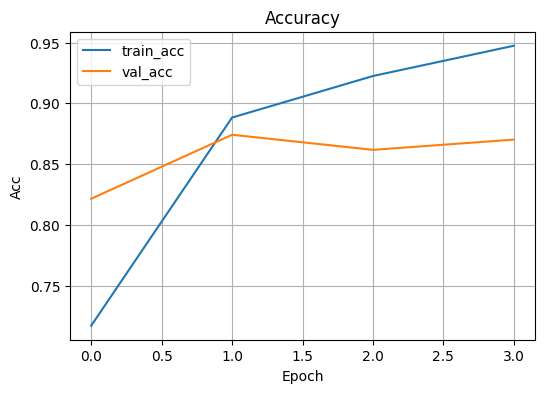

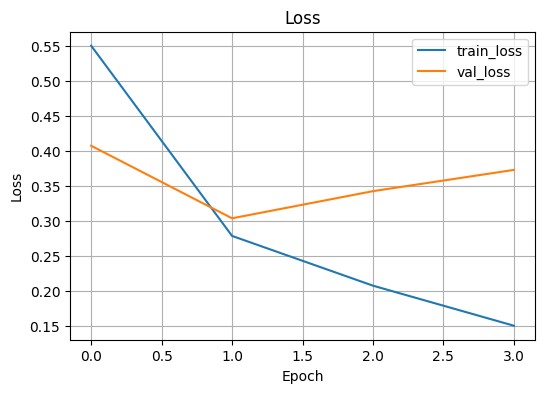

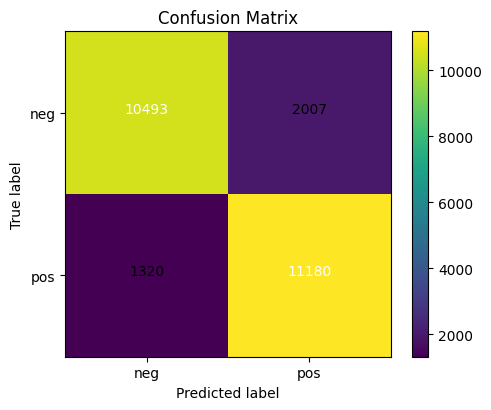

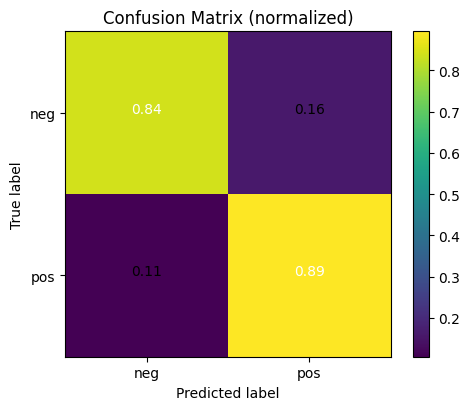

In [1]:
# ==============================================================
# LSTM + IMDB Sentiment (benchmark)
# • Hiperparámetros en CONFIG • Curvas y métricas
# ==============================================================

# 0) IMPORTS
import os, random, itertools
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import confusion_matrix, classification_report

# ----------------------------
# 1) HIPERPARÁMETROS (EDITA AQUÍ)
# ----------------------------
CONFIG = {
    # Datos
    "vocab_size": 20000,      # top-k palabras del vocabulario
    "maxlen": 300,            # longitud máxima por reseña (padding/truncado)
    "use_subset": False,      # True: usar subconjunto para acelerar pruebas
    "subset_train": 15000,
    "subset_test": 10000,

    # Entrenamiento
    "batch_size": 128,
    "epochs": 10,
    "validation_split": 0.2,
    "learning_rate": 1e-3,
    "early_stopping_patience": 2,

    # Modelo (LSTM)
    "embedding_dim": 128,
    "lstm_units": 128,
    "bidirectional": False,   # True: BiLSTM (más costo, suele mejorar)
    "dropout": 0.2,           # dropout en LSTM (recurrent_dropout requiere GPU cuDNN desactivado)

    # Reproducibilidad
    "seed": 42,
}

# ----------------------------
# 2) SEMILLA Y VERSIONES
# ----------------------------
def set_seeds(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds(CONFIG["seed"])
print("TensorFlow:", tf.__version__)

# ----------------------------
# 3) CARGA Y PREPROCESO (IMDB)
# ----------------------------
vocab_size = CONFIG["vocab_size"]
maxlen = CONFIG["maxlen"]
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=vocab_size)

if CONFIG["use_subset"]:
    x_train, y_train = x_train[:CONFIG["subset_train"]], y_train[:CONFIG["subset_train"]]
    x_test, y_test   = x_test[:CONFIG["subset_test"]],  y_test[:CONFIG["subset_test"]]

# Padding/truncado a longitud fija
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test  = keras.preprocessing.sequence.pad_sequences(x_test,  maxlen=maxlen)
print(f"Train: {x_train.shape} | Test: {x_test.shape}")

# ----------------------------
# 4) MODELO: LSTM
# ----------------------------
def build_lstm_model(cfg):
    """Construye un modelo LSTM para clasificación binaria."""
    inputs = keras.Input(shape=(cfg["maxlen"],), name="input_ids")
    x = layers.Embedding(cfg["vocab_size"], cfg["embedding_dim"], name="embedding")(inputs)

    # LSTM (puedes activar bidireccional)
    lstm_layer = layers.LSTM(cfg["lstm_units"], dropout=cfg["dropout"], name="lstm")
    if cfg["bidirectional"]:
        x = layers.Bidirectional(lstm_layer, name="bilstm")(x)
    else:
        x = lstm_layer(x)

    # Capa densa final con sigmoide para probabilidad
    outputs = layers.Dense(1, activation="sigmoid", name="logits")(x)
    model = keras.Model(inputs, outputs, name="LSTM_IMDB")

    # Compilación con Binary Crossentropy y Adam
    opt = keras.optimizers.Adam(learning_rate=cfg["learning_rate"])
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
    return model

model = build_lstm_model(CONFIG)
model.summary()

# ----------------------------
# 5) ENTRENAMIENTO
# ----------------------------
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=CONFIG["early_stopping_patience"],
        restore_best_weights=True
    )
]

history = model.fit(
    x_train, y_train,
    batch_size=CONFIG["batch_size"],
    epochs=CONFIG["epochs"],
    validation_split=CONFIG["validation_split"],
    callbacks=callbacks,
    verbose=1
)

# ----------------------------
# 6) EVALUACIÓN
# ----------------------------
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# Predicciones y umbral 0.5
y_prob = model.predict(x_test, batch_size=CONFIG["batch_size"], verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("\nClassification Report (test):")
print(classification_report(y_test, y_pred, target_names=["neg", "pos"], digits=4))

# ----------------------------
# 7) GRÁFICAS DE ENTRENAMIENTO
# ----------------------------
def plot_history(h):
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(h["accuracy"], label="train_acc")
    plt.plot(h["val_accuracy"], label="val_acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Acc")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(h["loss"], label="train_loss")
    plt.plot(h["val_loss"], label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history.history)

# ----------------------------
# 8) MATRIZ DE CONFUSIÓN
# ----------------------------
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(5.2,4.2))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=["neg","pos"], title="Confusion Matrix")
plot_confusion_matrix(cm, classes=["neg","pos"], normalize=True, title="Confusion Matrix (normalized)")
